In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_excel("POCM_HISTORICAL.xlsx")

In [4]:
df = data[["Checkout_Date", "Order_Quantity"]]
df.head()

,Checkout_Date,Order_Quantity
0,2018-12-04,1
1,2018-12-04,1
2,2018-12-05,5
3,2018-12-05,10
4,2018-12-05,20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160577 entries, 0 to 160576
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Checkout_Date   160577 non-null  datetime64[ns]
 1   Order_Quantity  160577 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 MB


### setting the checkout dates to index

In [6]:
df["year"] = df["Checkout_Date"].dt.year
df["month"] = df["Checkout_Date"].dt.month
df["month"] = [m.strftime("%b") for m in df["Checkout_Date"]]
df.head()

C:\Users\ACer\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\ACer\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Checkout_Date,Order_Quantity,year,month
0,2018-12-04,1,2018,Dec
1,2018-12-04,1,2018,Dec
2,2018-12-05,5,2018,Dec
3,2018-12-05,10,2018,Dec
4,2018-12-05,20,2018,Dec


In [7]:
df["Checkout_Date"].max() - df["Checkout_Date"].min()

Timedelta('528 days 00:00:00')

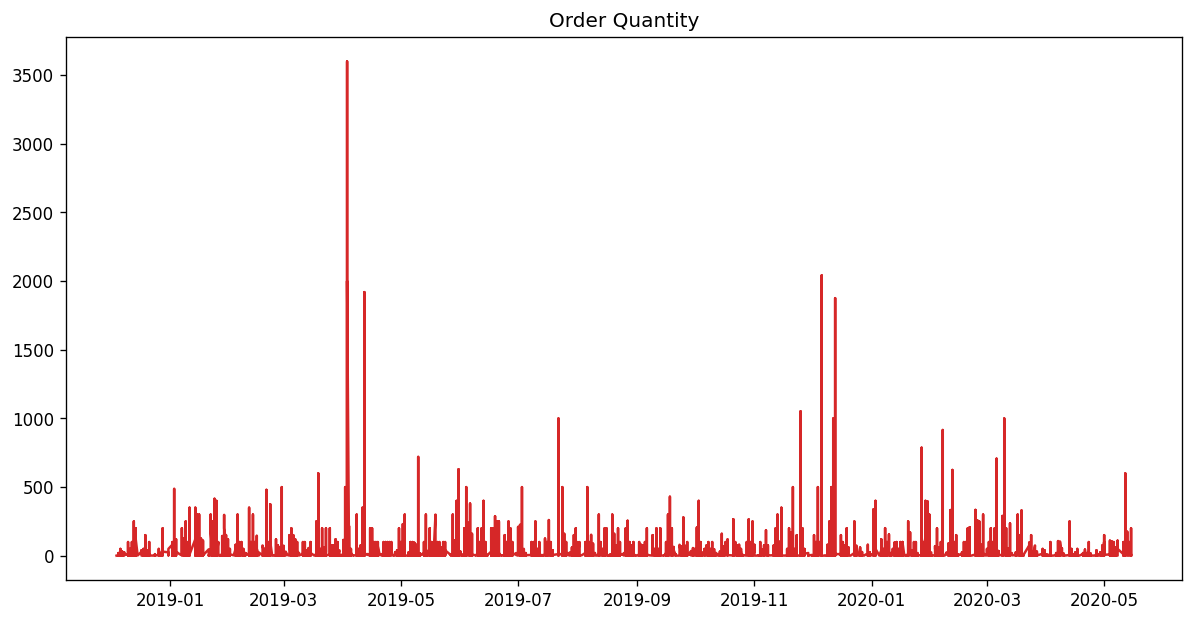

In [8]:
plt.figure(figsize=(12,6), dpi=120)
plt.plot(df["Checkout_Date"], df["Order_Quantity"], color="tab:red")
plt.gca().set(title="Order Quantity")
plt.show()

## As we can see no trend is Observed

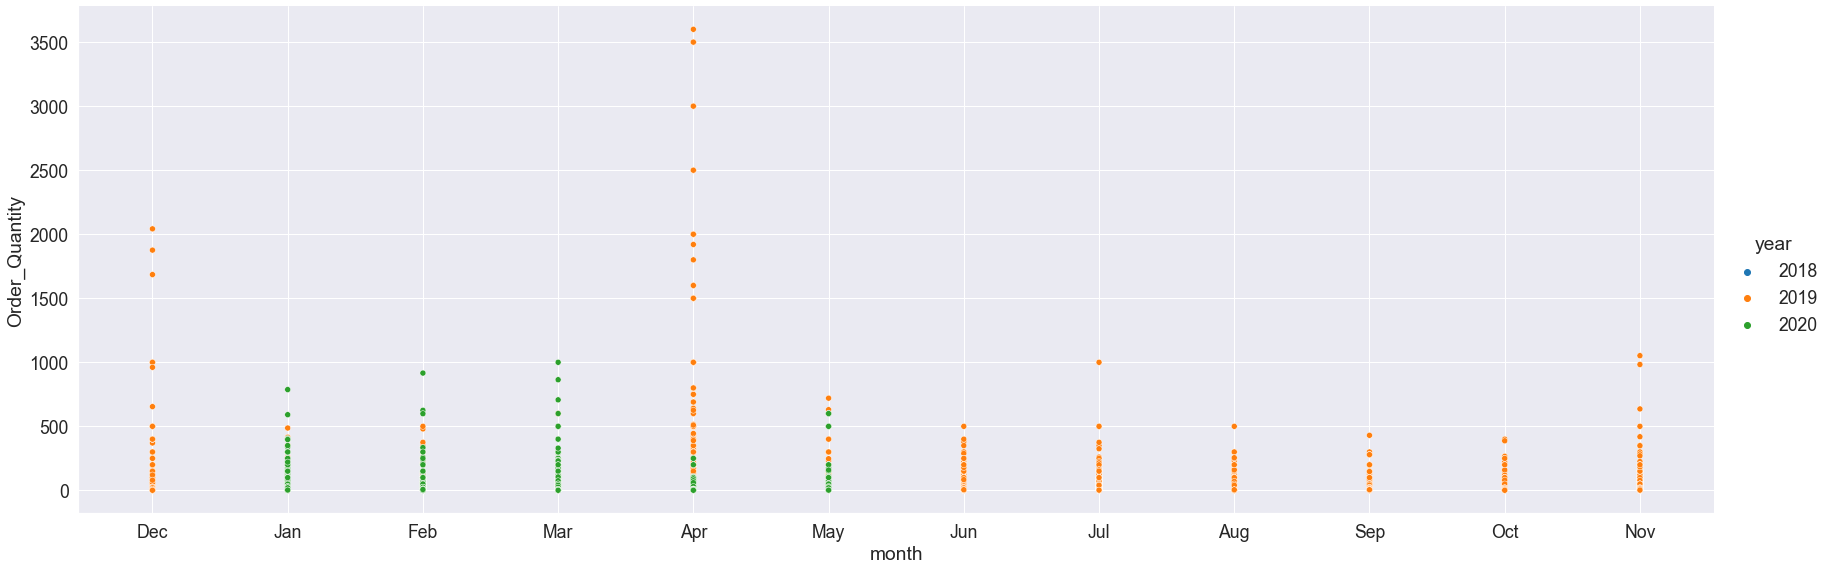

In [32]:
# plt.figure(figsize=(12,6),dpi=100)
sns.relplot(data=df, x="month", y="Order_Quantity", height=8, aspect=3, hue="year", palette="tab10")
sns.set(font_scale=1.8)
plt.show()

## Test for Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller
# Ho : Not stationary Ts
# Ha : Stationary Ts
result = adfuller(df["Order_Quantity"].dropna().values, autolag="AIC")

In [12]:
print(f"p value: {result[1]}\nADF Statistic: {result[0]}")
for k,v in result[4].items():
    print(f"Critical Values: {k}:{v}")

p value: 0.0
ADF Statistic: -38.973674207703155
Critical Values: 1%:-3.4303907429384073
Critical Values: 5%:-2.861558007815263
Critical Values: 10%:-2.566779584916894


### The p-value obtained is within the significance level(0.05) and the ADF statistic is lesser than any of the critical values. Clearly, there is no reason to reject the alternate hypothesis. So, the time series is Stationary.

## Lets check for the order of AR terms

### You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

In [13]:
# determining p & q
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

C:\Users\ACer\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


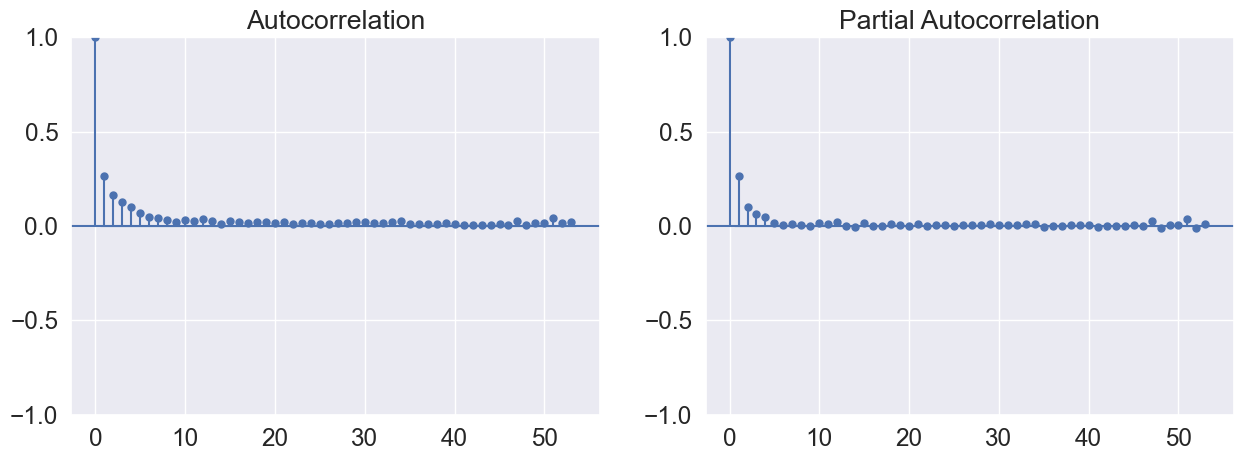

In [14]:
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi=100)
plot_acf(df["Order_Quantity"].dropna(), ax=axes[0])
plot_pacf(df["Order_Quantity"].dropna(),ax=axes[1])
plt.show()

### Since both the plots show gradual change, we go with ARMA model with TS being Stationary

### I dont see any significance region to pick our lags for p and q in pacf, acf repectively
#### lets take p order upto 2
#### and take q order upto 3

## Test and Train datasets

In [29]:
train = df.iloc[:160470, [0,1]]
test = df.iloc[160470:, [0,1]]

In [30]:
# setting their indexes
train.set_index("Checkout_Date", inplace=True)
test.set_index("Checkout_Date", inplace=True)

In [31]:
print(train.shape)
print(test.shape)

(160470, 1)
(107, 1)


## build ARIMA model

In [33]:
# building manually
# order = (2,0,1)
order = (1,0,1)
# order = (0,0,1)
# just autoregression (1,0,0)

In [34]:
from statsmodels.tsa.arima.model import ARIMA

In [35]:
model = ARIMA(endog=df["Order_Quantity"], order=order)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:               160577
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -794353.308
Date:                Mon, 31 Jan 2022   AIC                        1588714.615
Time:                        13:59:21   BIC                        1588754.561
Sample:                             0   HQIC                       1588726.485
                             - 160577                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7026      0.241     40.283      0.000       9.231      10.175
ar.L1          0.7019      0.001   1190.282      0.000       0.701       0.703
ma.L1         -0.4855      0.001   -693.888      0.000      -0.487      -0.484
sigma2      1161.9174      0.156   7440.236      0.000    1161.611    1162.224
===================================================================================
Ljung-Box (L1) (Q):                  15.29   Jarque-Bera (JB):       75911613755.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            44.38
Prob(H) (two-sided):                  0.00   Kurtosis:                      3370.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Get Predictions for the test

In [36]:
prediction = pd.Series(fit.forecast(len(test)))
prediction = prediction.map(lambda x: x if x>= 0 else 0)
prediction.head()

160577    7.068443
160578    7.853738
160579    8.404919
160580    8.791783
160581    9.063314
Name: predicted_mean, dtype: float64

In [37]:
# actual values
actual_value = test["Order_Quantity"]

In [38]:
# Evaluation Metric
from sklearn.metrics import mean_squared_error
from math import sqrt

In [39]:
# Root Mean Squared Error (RMSE)
rmse = np.mean((prediction.values - actual_value.values)**2)**.5
rmse

33.50684142217028

In [40]:
# Kanth's way
rmse=sqrt(mean_squared_error(prediction,actual_value))
print(rmse)

33.50684142217028


In [41]:
# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs(prediction.values - actual_value.values)/np.abs(actual_value.values))
print(mape)

2.4549948751659407


## Plotting predictions

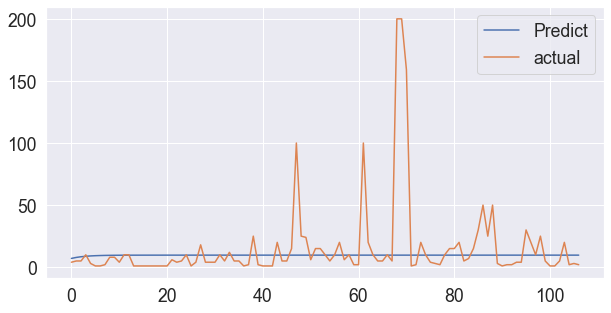

In [43]:
plt.figure(figsize=(10,5))
plt.plot(prediction.values, label="Predict")
plt.plot(actual_value.dropna().values, label="actual")
plt.legend()
plt.show()

## Using Auto ARIMA

In [27]:
import pmdarima as pm
model = pm.auto_arima(df["Order_Quantity"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=1, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1592088.291, Time=6.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1614401.115, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1597672.029, Time=0.81 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1601597.546, Time=4.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=17.82 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1594674.317, Time=1.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1588714.303, Time=16.37 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1593508.315, Time=11.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1591327.664, Time=1.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1588580.562, Time=32.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1589676.228, Time=2.00 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 95.904 seconds


In [28]:
stepwise_fit = pm.auto_arima(train['Order_Quantity'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1588479.017, Time=73.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1664857.225, Time=1.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1631671.588, Time=1.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1597633.563, Time=10.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1664855.225, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=67.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=47.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=62.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=94.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=24.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=87.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=39.65 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=838.68 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=33.81 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Tota

In [44]:
# arima auto model approach
model2 = ARIMA(df["Order_Quantity"], order=(2,0,1))
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:               160577
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -794285.292
Date:                Mon, 31 Jan 2022   AIC                        1588580.583
Time:                        14:10:35   BIC                        1588630.516
Sample:                             0   HQIC                       1588595.421
                             - 160577                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7026      0.252     38.571      0.000       9.210      10.196
ar.L1          0.8547      0.002    494.212      0.000       0.851       0.858
ar.L2         -0.0610      0.001   -110.828      0.000      -0.062      -0.060
ma.L1         -0.6286      0.002   -362.289      0.000      -0.632      -0.625
sigma2      1159.2410      0.156   7440.423      0.000    1158.936    1159.546
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):       76347625573.82
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            44.44
Prob(H) (two-sided):                  0.00   Kurtosis:                      3379.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#predictions
prediction2 = pd.Series(fit.forecast(len(test)))
prediction2 = prediction2.map(lambda x: x if x>= 0 else 0)
prediction2.head()

160577    7.068443
160578    7.853738
160579    8.404919
160580    8.791783
160581    9.063314
Name: predicted_mean, dtype: float64

In [46]:
# Root Mean Squared Error (RMSE)
rmse2 = np.mean((prediction2.values - actual_value.values)**2)**.5
print(f"RMSE_2: {rmse2}")
# Mean Absolute Percentage Error (MAPE)
mape2 = np.mean(np.abs(prediction2.values - actual_value.values)/np.abs(actual_value.values))
print(f"MAPE_2 : {mape2}")

RMSE_2: 33.50684142217028
MAPE_2 : 2.4549948751659407


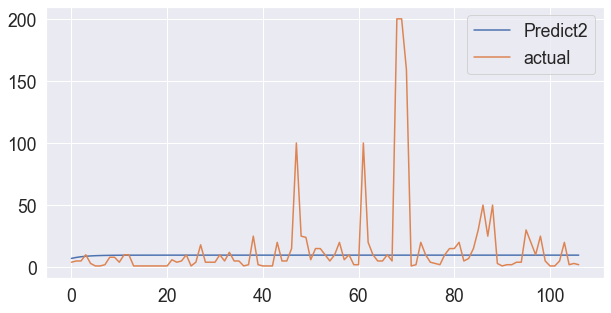

In [47]:
#prediction2 plotting
plt.figure(figsize=(10,5))
plt.plot(prediction2.dropna().values, label="Predict2")
plt.plot(actual_value.dropna().values, label="actual")
plt.legend()
plt.show()

In [51]:
print(f"actual: {actual_value.values}\npredictions2: {prediction2.values}")

actual: [  4   5   5  10   3   1   1   2   8   8   4  10  10   1   1   1   1   1
   1   1   1   6   4   5  10   1   4  18   4   4   4  10   5  12   5   5
   1   2  25   2   1   1   1  20   5   5  15 100  25  24   6  15  15  10
   5  10  20   6  10   2   2 100  20  10   5   5  10   5 200 200 159   1
   2  20  10   4   3   2  10  15  15  20   5   7  15  30  50  25  50   3
   1   2   2   4   4  30  20  10  25   5   1   1   5  20   2   3   2]
predictions2: [7.06844344 7.8537375  8.40491942 8.7917828  9.06331434 9.2538968
 9.38766275 9.48155035 9.54744815 9.59370047 9.62616403 9.64894955
 9.66494224 9.67616718 9.68404574 9.68957554 9.6934568  9.69618097
 9.69809301 9.69943504 9.70037697 9.7010381  9.70150213 9.70182783
 9.70205643 9.70221688 9.70232949 9.70240853 9.70246401 9.70250295
 9.70253028 9.70254947 9.70256293 9.70257238 9.70257901 9.70258367
 9.70258694 9.70258923 9.70259084 9.70259197 9.70259276 9.70259332
 9.70259371 9.70259398 9.70259418 9.70259431 9.70259441 9.70259447
 9.70259

## Trying a diffferent approach

C:\Users\ACer\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


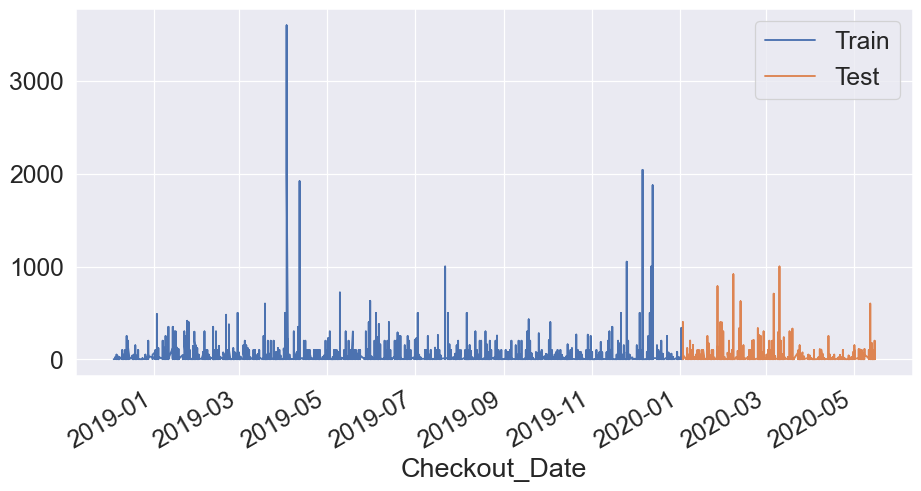

In [34]:
# Trying out different approach
train2 = df[:int(0.7*(len(df)))]
test2 = df[int(0.7*(len(df))):]
train2.set_index("Checkout_Date", inplace=True)
test2.set_index("Checkout_Date", inplace=True)
train2.drop(columns=["year","month"], inplace=True)
test2.drop(columns=["year","month"], inplace=True)
plt.figure(figsize=(12,6), dpi=90)
train2["Order_Quantity"].plot(label="Train")
test2["Order_Quantity"].plot(label="Test")
plt.legend()
plt.show()

In [22]:
#building a model
from pmdarima import auto_arima
model3 = auto_arima(train2, trace=True, error_action='ignore', suppress_warnings=True)
model3.fit(train2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=123.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1194955.231, Time=2.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1171446.452, Time=2.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1147542.077, Time=18.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1194953.231, Time=1.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=51.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=44.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=85.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1147540.077, Time=6.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=16.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=15.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1171444.452, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=35.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 403.178 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
#forecasting 
forecast = model3.predict(n_periods=len(test2))
forecast = pd.DataFrame(forecast,index = test2.index,columns=['Prediction'])
forecast

,Prediction
Checkout_Date,
2020-01-03,8.426551
2020-01-03,8.426551
2020-01-03,8.426551
2020-01-03,8.426551
2020-01-03,8.426551
...,...
2020-05-15,8.426551
2020-05-15,8.426551
2020-05-15,8.426551


### actual vs predictions

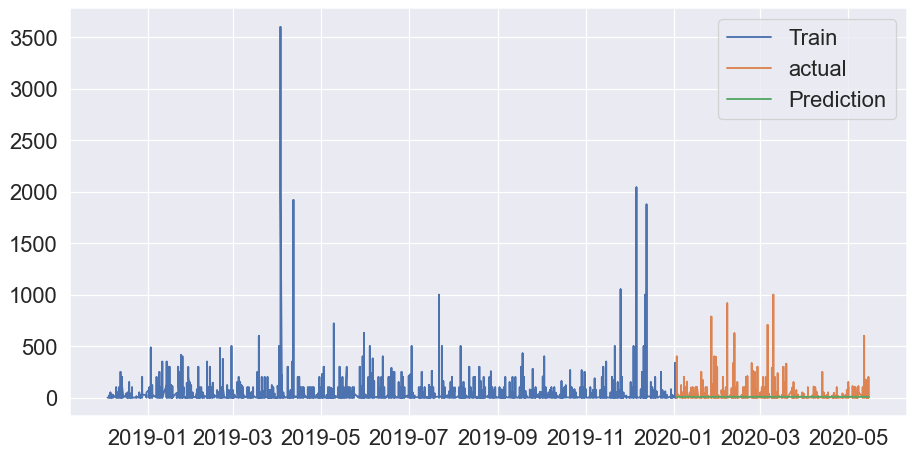

In [26]:
# plot the prediction for validation
plt.figure(figsize=(12,6),dpi=90) 
plt.plot(train2, label='Train')
plt.plot(test2, label='actual')
plt.plot(forecast, label='Prediction')
plt.legend()
plt.show()

In [27]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test2,forecast))
print(rms)

19.906559263954897


## Decompose a time series into its component

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [73]:
new_df = df[["Checkout_Date","Order_Quantity"]]
new_df["Date"] = pd.to_datetime(new_df["Checkout_Date"])
new_df.set_index("Date", inplace=True)
new_df.head()

C:\Users\ACer\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Checkout_Date,Order_Quantity
Date,,
2018-12-04,2018-12-04,1
2018-12-04,2018-12-04,1
2018-12-05,2018-12-05,5
2018-12-05,2018-12-05,10
2018-12-05,2018-12-05,20


In [74]:
final = seasonal_decompose(new_df['Order_Quantity'],model='additive') # annual=1,Quaterly=4,monthly=12,weekly=52
final.plot();



ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

## Seasonal ARIMA model

In [75]:
smodel = pm.auto_arima(df["Order_Quantity"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1338.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1707863.161, Time=12.33 sec


MemoryError: Unable to allocate 766. MiB for an array with shape (25, 25, 160577) and data type float64

In [3]:
data.columns

Index(['Checkout_Date', 'Order_Nbr', 'Item_Nbr', 'Zip_Code', 'WSLR_Nbr',
       'Ship_Date', 'Brand', 'Partition', 'Item_Description', 'Category',
       'Carton_Factor', 'City', 'State', 'Supplier', 'Lead_Date_in_Weeks',
       'Brand_Code', 'Cost', 'Item_Active', 'Weekly_Avg_Qty_Sold',
       'On_Hand_Inventory', 'On_Order_Inventory', 'Pending_WO_Inventory',
       'Remaining_Inventory_Weeks', 'Order_Quantity', 'LastModId',
       'LastModMachine', 'LastModApp', 'LastModTsp'],
      dtype='object')